## Portfolio Exercise Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their candidates.   The data for this exercise consists of about 120,000 data points split in 2:1 ratio among training and test files. Each data point includes one column indicating whether or not an individual was sent a promotion for a specific product, and one column indicating whether or not that individual eventually purchased that product. Each individual also had seven additional features associated with them.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user.  Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

Ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group.

* **Net Incremental Revenue (NIR)**

The total number of purchasers that received the promotion times 10 minus the number of promotions given times 0.15 minus the number of purchasers who were not given the promotion times 10.

For a full description of what starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the **promotion_strategy** function to pass to the **test_results** function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers.  

|   | Actual      |    |    | 
|---|-------------|----|----|
| **Predicted**   | Yes| No |  
| Yes             | **I**   | **II**|  
| No              | **III** | **IV**|  

The metrics are only being compared for the individual's we predict should obtain the promotion - that is quadrants I and II here.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equal participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 


Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final test_results function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('data/training.csv')
test_data = pd.read_csv('data/Test.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [2]:
from sklearn.metrics import f1_score,make_scorer
from sklearn.svm import SVC

In [ ]:
from sklearn.preprocessing import StandardScaler

In [4]:
train_data['Promotion'].value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

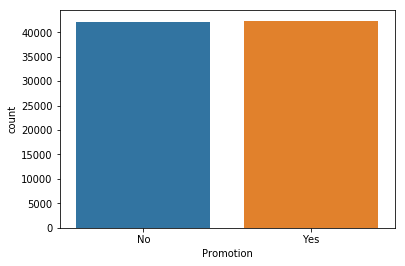

In [6]:
sb.countplot(x='Promotion',data=train_data)

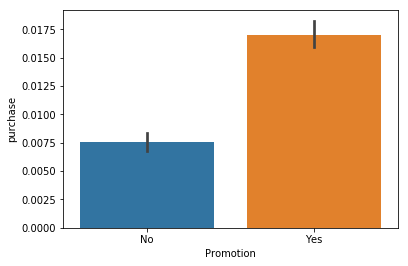

In [7]:
sb.barplot(x='Promotion',y='purchase',data=train_data)

In [9]:
train_data['purchase'].value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

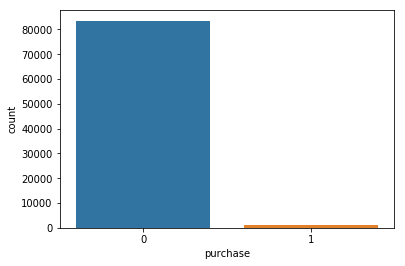

In [8]:
sb.countplot(x='purchase',data=train_data)

We can see that the percentage of who purchase the product is very small

In [10]:
train_data.groupby(by='Promotion')['purchase'].value_counts()

Promotion  purchase
No         0           41851
           1             319
Yes        0           41643
           1             721
Name: purchase, dtype: int64

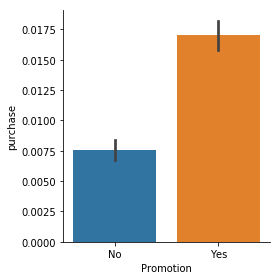

In [36]:
sb.factorplot(x='Promotion',y='purchase',data=train_data,kind='bar')

We can see that there is big difference in customer behavior due to promotion that channce of purchase increased by more than double

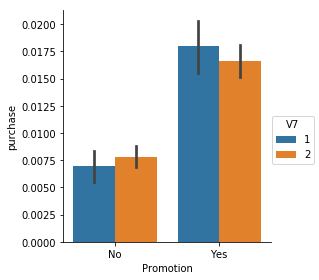

In [43]:
sb.factorplot(x='Promotion',y='purchase',data=train_data,kind='bar',hue='V7')

We can see change in behavior as in case of no promotion the individuals that has value of 2 w.r.t column V7 has less purchase but in case of promotion they have higher purchase 

In [46]:
train_data.groupby(by=['Promotion','V7'])['purchase'].value_counts()

Promotion  V7  purchase
No         1   0           12471
               1              87
           2   0           29380
               1             232
Yes        1   0           12431
               1             228
           2   0           29212
               1             493
Name: purchase, dtype: int64

Trying baseline model that will send promotion to every one

In [3]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    
    
    
    return promotion

In [4]:
# This will test your results, and provide you back some information 
# on your how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.01.

Your nir with this strategy is -1132.20.
Approximately, the highest scores obtained at Udacity were: irr of 0.1 and an nir of 300.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

We will try different models, validate them on subset of training data and then test them on our success metrics IRR,NRI

first we predict 1 for those only have promotions and made purchase

In [7]:
response =[]
for index,row in train_data.iterrows():
    if (row['Promotion']== 'Yes') and (row['purchase']==1) :
        response.append(1)
    else:
        response.append(0)
train_data['response']=response

print(train_data.head())

   ID  Promotion  purchase  V1         V2        V3  V4  V5  V6  V7  response
0   1          0         0   2  30.443518 -1.165083   1   1   3   2         0
1   3          0         0   3  32.159350 -0.645617   2   3   2   2         0
2   4          0         0   2  30.431659  0.133583   1   1   4   2         0
3   5          0         0   0  26.588914 -0.212728   2   1   4   2         0
4   8          0         0   3  28.044332 -0.385883   1   1   2   2         0


In [14]:
train_data_features=train_data.drop(['ID','Promotion','purchase','response'],axis=1)
train_data_output=train_data['response']

In [5]:
train_data['Promotion']=train_data.Promotion.eq('yes').mul(1)

In [42]:
pd.DataFrame(train_data).sample(5)

,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,response
68717,0,0,2,29.705115,0.220161,2,3,4,2,0
63800,0,0,2,32.185505,-0.645617,1,3,1,2,0
33984,0,0,2,28.873306,-1.597972,1,4,1,1,0
69229,0,0,2,36.774796,1.259095,1,3,4,2,0
42118,0,0,1,28.064375,-0.472461,1,2,4,2,0


In [35]:

X_train,X_valid,Y_train,Y_valid= train_test_split(train_data_features,
                                                  train_data_output,
                                                  test_size=0.2,stratify=train_data_output)


In [37]:
Y_train.value_counts()

0    67627
Name: response, dtype: int64

In [33]:
svmmodel=SVC(C=1,kernel='linear')
svmmodel.fit(X=X_train.values,y=Y_train.values)

ValueError: The number of classes has to be greater than one; got 1

In [48]:
train_score=f1_score(svmmodel.predict(X_train),Y_train)
valid_score=f1_score(svmmodel.predict(X_valid),Y_valid)

In [49]:
print('f1 score on training    '+str(train_score))
print('f1 score on validation   '+str(valid_score))


f1 score on training    0.8069345941686368
f1 score on validation   0.7625418060200668


In [52]:
test_data.Promotion=test_data.Promotion.eq('Yes').mul(1)
test_data=test_data.drop('ID',axis=1)
test_data.head()

,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,0,0,1,41.376390,1.172517,1,1,2,2
1,1,0,1,25.163598,0.653050,2,2,2,2
2,1,0,1,26.553778,-1.597972,2,3,4,2
3,0,0,2,28.529691,-1.078506,2,3,2,2
4,0,0,2,32.378538,0.479895,2,2,1,2


In [63]:
print(type(X_valid))

<class 'pandas.core.frame.DataFrame'>


In [68]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    predictions=svmmodel.predict(test)
    for i in range(num_test_points):
        if predictions[i]>0.5:
            
            promotion.append('Yes')
        else:
            promotion.append('No')
        
    promotion = np.array(promotion)
    
    
    
    
    return promotion

In [69]:
test_results(promotion_strategy)

ValueError: X.shape[1] = 7 should be equal to 9, the number of features at training time

In [ ]:
Model 2: Using Two Models
In this approach, we will train two models. One model will be trained on the treatment group (those who received the promotion) and we will refer to this model as the treatment model. Another model will be trained on the control group (those who did not received the promotion), and we will refer to this as the control model. The target of both models will be whether the individual made the purchase or not. The treatment model will predict the probability that individual will make a purchase if he or she received the promotion, while the control model will predict the probability that individual will make a purchase if he or she did not receive the promotion. Ideally the difference in the probabilities, which we will call the lift:

Lift = P(purchase | treatment) - P(purchase | control) $$
will tell us the probability that sending a promotion to an individual will increase his or her willingness to make a purhcase vs not sending a promotion. We can then send promotions to individuals with lift values higher than a pre-defined cutoff percentile. For example, we can send promotions to individuals in the top 3 deciles.

For this dataset, we can manually try a few cutoff percentiles or perform a grid search to find the optimal cut-off percentile. In this example, a manual search was conducted for simplicity sake. The performance of this model left a lot to be desired. Sending out promotions to individuals with lift values above the 97th percentile seems to be one of the better option. An irr of 0.44\% and nlr of \$26.90 is achieved on the validation set. On the other hand, an irr of 1.76\% and nlr of \\$12.70 is achieved for the test data, which is not as good as the Starbuck's model. It should also be noted that this method is extremely sensitive to changes in the cut-off percentile used for this dataset. Both the addition or subtraction of a few percentiles resulted in drastically different nlr. Hence, the two model approach is not recommended for this data set.

As noted in the presentation on Uplift Modeling by Victor Lo found here, one of the disadvantages of this method is that it indirectly models uplift. The difference between the treatment and control probabilities may sometimes be noise. In addition, there is also the possibility that the scales of both models don't match.

We will try different approach we will train 2 models one for control group called (control model) that produce probability for individuals to make purchase or not
the second model for experiment group (individuals who receive promotions) that produce probability for individuals to make purchase or not giving that the received promotion
the difference between probabilities calculate the effect of promotion and it's called (lift) how it increase chance of making purchace

In [39]:
train_data = pd.read_csv('data/training.csv')

control_data=train_data[train_data['Promotion']=='No']
experiment_data=train_data[train_data['Promotion']=='Yes']


control_features=control_data.drop(['ID','Promotion','purchase'],axis=1)

control_output=control_data['purchase']


experiment_features=experiment_data.drop(['ID','Promotion','purchase'],axis=1)

experiment_output=experiment_data['purchase']

In [40]:
X_con_train,X_con_valid,Y_con_train,Y_con_valid= train_test_split(control_features,control_output,test_size=0.2)
X_exp_train,X_exp_valid,Y_exp_train,Y_exp_valid= train_test_split(experiment_features,experiment_output,test_size=0.2)

In [41]:
svmmodel_con=SVC(C=1,kernel='linear')
svmmodel_con.fit(X_con_train,Y_con_train)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [92]:
y_con_pred=svmmodel_con.predict(X_con_train)
y_con_pred_valid = svmmodel_con.predict(X_con_valid)

predictions=[1 if i >=0.5 else 0 for i in y_con_pred ]


train_score_con=f1_score(Y_con_train.values,y_con_pred,average='micro')
valid_score_con=f1_score(Y_con_valid,y_con_pred_valid,average='micro')

In [93]:
print('f1 score on control training data is '+str(train_score_con))
print('f1 score on control validation data is '+str(valid_score_con))

f1 score on control training data is 0.9922338155086554
f1 score on control validation data is 0.9932416409769979


In [ ]:
svmmodel_exp=SVC(C=1,kernel='linear')
svmmodel_exp.fit(X_exp_train,Y_exp_train)


In [68]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    predictions=svmmodel.predict(test)
    for i in range(num_test_points):
        
        if predictions[i]>0.5:
            
            promotion.append('Yes')
        else:
            promotion.append('No')
        
    promotion = np.array(promotion)
    
    
    
    
    return promotion